# Empirial data tutorial

## A) Occurrence count in raster

In this tutorial you will download species occurrence data of your species of choice from GBIF and plot the number of occurrences per cell for a country of choice.

<div class="alert alert-block alert-warning">
Task: Choose your own species and country when going through the following steps. Make sure you pick a species with sufficient available records (see command for checking this in the next code cell), otherwise the resulting raster will look quite boring. In the example I'm working with the species Aquila chrysaetos (golden eagle) in Sweden.
</div>


### 1. Getting the data
Here we we use the R package `rgbif` to download occurrence data directly from GBIF into R. Let's see how many occurrences we can find for golden eagles in Sweden. You can use the `publishingCountry=` option to only extract occurrences from a given country. Another useful argument is `hasCoordinate = T`, which only allows records with valid coordinates. You can choose to only extract summary data `return =  "meta"` in order to first get an idea how many data points there are, before starting to download. This is recommendable because it can take a very long time to download tens of thousands of occurrences, so it's best to know beforehand what you are in for.

In [1]:
library(rgbif)
occ_search(scientificName = "Aquila chrysaetos", publishingCountry='SE', hasCoordinate = T, return =  "meta")$count

[1] 71238

Now let's download the data by setting `return =  "data"`. For this exercise you can keep the number of data points in a managable range by setting a limit, e.g. `limit=10000`:

In [2]:
golden_eagle <- occ_search(scientificName = "Aquila chrysaetos", publishingCountry='SE',hasCoordinate = T,return =  "data", limit = 5000)
#library(tidyverse)
#write_csv(x = golden_eagle, path = "./data/golden_eagle.csv")

This is how you extract the longitude and latitude information from the `occ_search()` output. The command `cbind()` turns these two data arrays into a matrix:

In [3]:
lon = golden_eagle$decimalLongitude
lat = golden_eagle$decimalLatitude
locations = cbind(lon, lat)

As before in the intor tutorial, we will use the `SpatialPoints()` function to turn this matrix into a `SpatialPoints` object:

In [8]:
library(sp)
eagle_data_spatial <- SpatialPoints(locations)

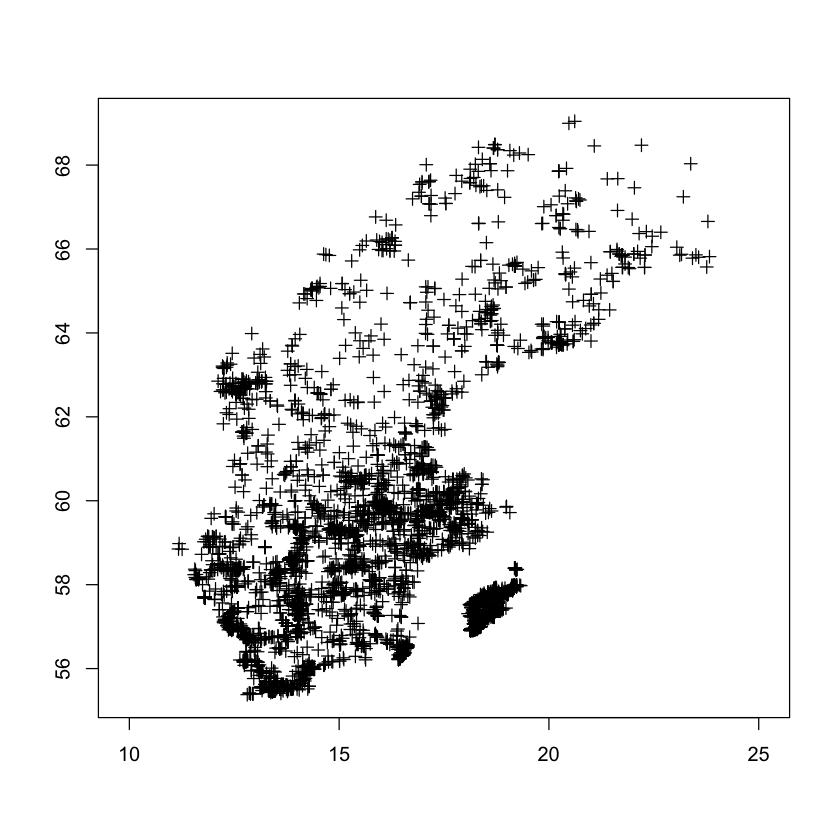

In [9]:
plot(eagle_data_spatial,axes=T)

### Loading a country map (Sweden)
I stored a file containing simple maps of all countries in the `data/ne_10m_admin_0_countries/` folder. Read the data using the `st_read()` function from the `sf` library.

In [10]:
library(sf)
setwd('/Users/tobias/GitHub/workshops/ggbc_slw_neic/spatial_r_workshop/')
all_countries = st_read('./data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')

Reading layer `ne_10m_admin_0_countries' from data source `/Users/tobias/GitHub/workshops/ggbc_slw_neic/spatial_r_workshop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp' using driver `ESRI Shapefile'
Simple feature collection with 255 features and 94 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -180 ymin: -90 xmax: 180 ymax: 83.6341
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


Extract the data of your country of choice from the `all_countries` object and convert the data into a spatial object using the `as(...,'Spatial')` function:

In [11]:
swe_index = which(all_countries$SOVEREIGNT == 'Sweden')
sweden_sf = all_countries[swe_index,1]
sweden = as(sweden_sf, 'Spatial')

Now plot the data points on the map of your country:

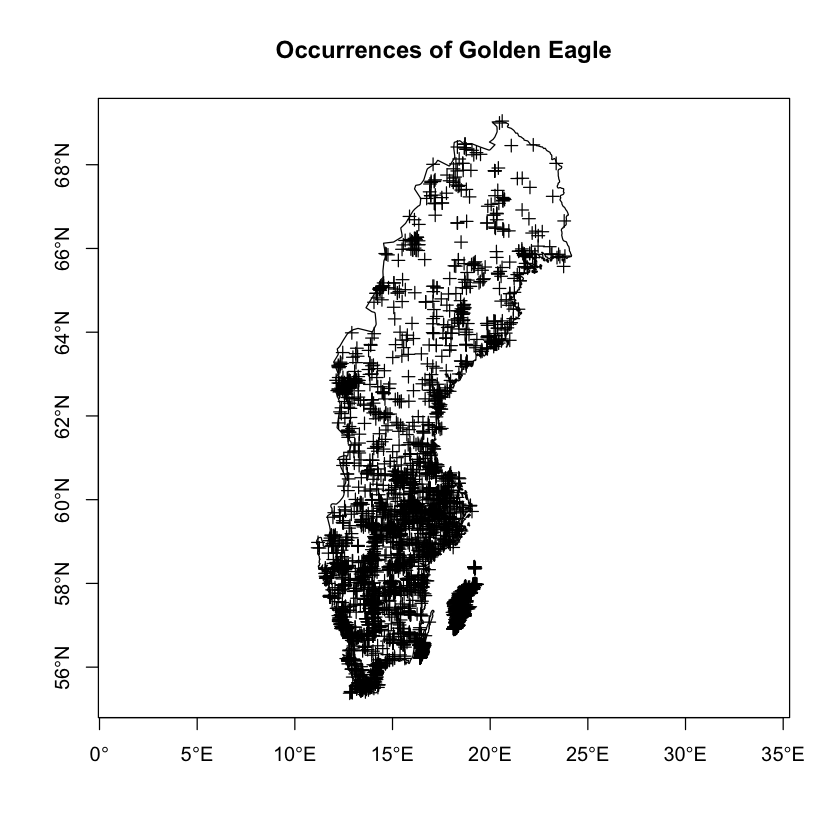

In [12]:
plot(sweden,main='Occurrences of Golden Eagle',axes=T)
plot(eagle_data_spatial,add=T)

### Count occurrences per grid cell
Now convert the country polygon into a raster and then count for each cell the number of occurrences of your species of choice. 

When using the `raster()` function you can set the resolution (in degrees int his case) to any value you like. The smaller the value, the smaller the cells and hence the more cells are being produced.

Then use the `rasterize()` function to rasterize the point data, providing the `SpatialPoints` object followed by the `raster` object, followed by the formula of what needs to be done (`fun=`), in our case you can use the keyword `'count'`, which will count the number of points that fall within each cell.

In [14]:
sweden

class       : SpatialPolygonsDataFrame 
features    : 1 
extent      : 11.10816, 24.16341, 55.34268, 69.03636  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs 
variables   : 1
names       :      featurecla 
value       : Admin-0 country 

In [13]:
library(raster)
raw_raster <- raster(sweden,resolution=0.4)
counts_per_cell = rasterize(eagle_data_spatial,raw_raster,fun='count')

Plot the resulting raster values:

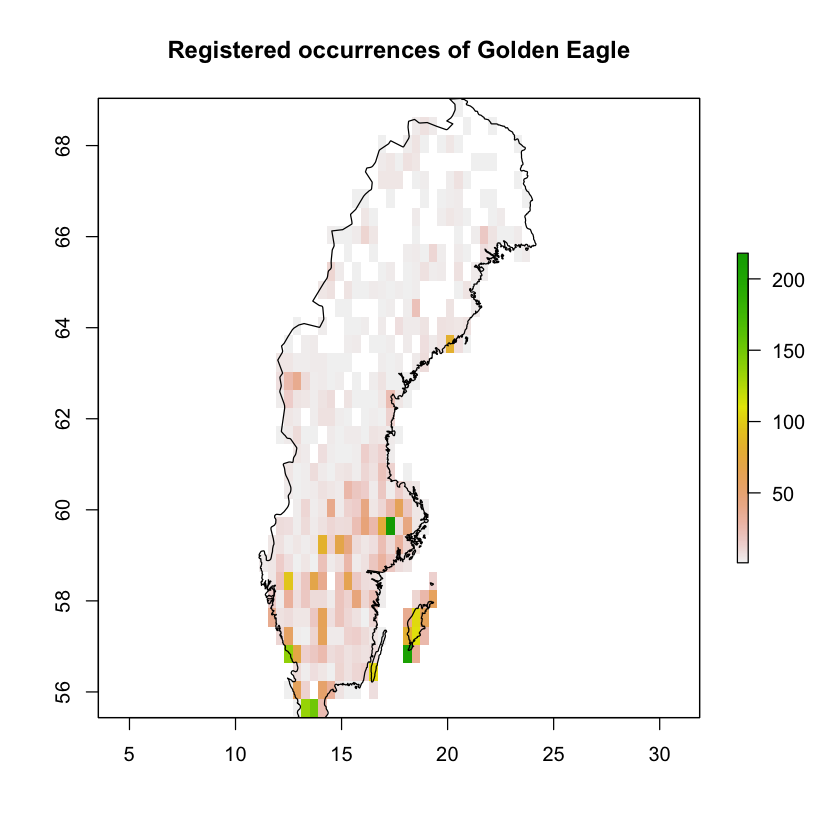

In [272]:
plot(counts_per_cell, main='Registered occurrences of Golden Eagle')
plot(sweden,add=T)

## B) Plotting mammal diversity

In the exercise above we counted the number of occurrence points for each cell of a given raster. Now we are going to use the information of many individual presence/absence rasters (cells coded as 1 or 0) for all mammal species and add the values in each cell across all rasters in order to plot a map of global mammal diversity.

As input data we are going to use the "present natural" rasters, produced by a recent study by Faurby et al, 2015 ('Historic and prehistoric human-driven extinctions have reshaped global mammal diversity patterns'). In this study the authors modeled ranges of each species under a scenario of no human disturbance (where would species occur if no humans were present).

The raster files can be found in `./data/present_natural_converted/`. There is one separate raster file per species and in the raster each cell is coded as 0 (species absent) or 1 (species present). Since we can just add values across different rasters, we can simply iterate through all raster files (using a `for(){}` loop) and keep adding them up, which will give us the total diversity for each cell. **This will take approx. 5 minutes!**

In [273]:
library(raster)

setwd('/Users/tobias/GitHub/workshops/ggbc_slw_neic/spatial_r_workshop/')
species_ranges=list.files('./data/present_natural_converted/')

rasters = raster(sprintf('./data/present_natural_converted/%s',species_ranges[1]))
for (i in species_ranges[2:length(species_ranges)]){
    species_raster=raster(sprintf('./data/present_natural_converted/%s',i))
    rasters = rasters+species_raster
    }

Plot the resulting raster of mammal species diversity:

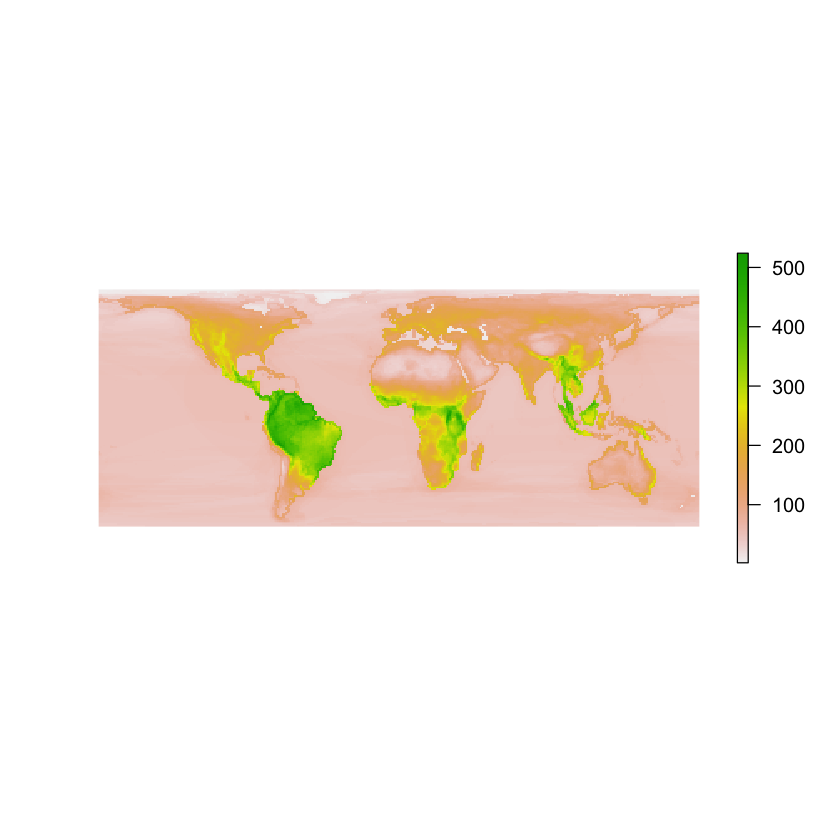

In [274]:
plot(rasters,axes=F,box=FALSE)

You can already see that mammal diversity is distributed unevenly across the globe. However we have not yet delimited the geographoc features, the only reason why you can see where the continent are placed is because the structure of the diversity data. Now we want to delimit land from water, by plotting a world-map polygon on top of this raster. Load the world map stored at `global/ne_50m_land/ne_50m_land.shp`:

In [275]:
library(sf)
world = st_read('./data/global/ne_50m_land/ne_50m_land.shp')
world_spatial = as(world, 'Spatial')

Reading layer `ne_50m_land' from data source `/Users/tobias/GitHub/workshops/ggbc_slw_neic/spatial_r_workshop/data/global/ne_50m_land/ne_50m_land.shp' using driver `ESRI Shapefile'
Simple feature collection with 1420 features and 3 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -180 ymin: -89.99893 xmax: 180 ymax: 83.59961
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


Now let's plot the world polygon on top of the raster data to delimit land from water (hint: it's supposed to not work out properly, see next section).

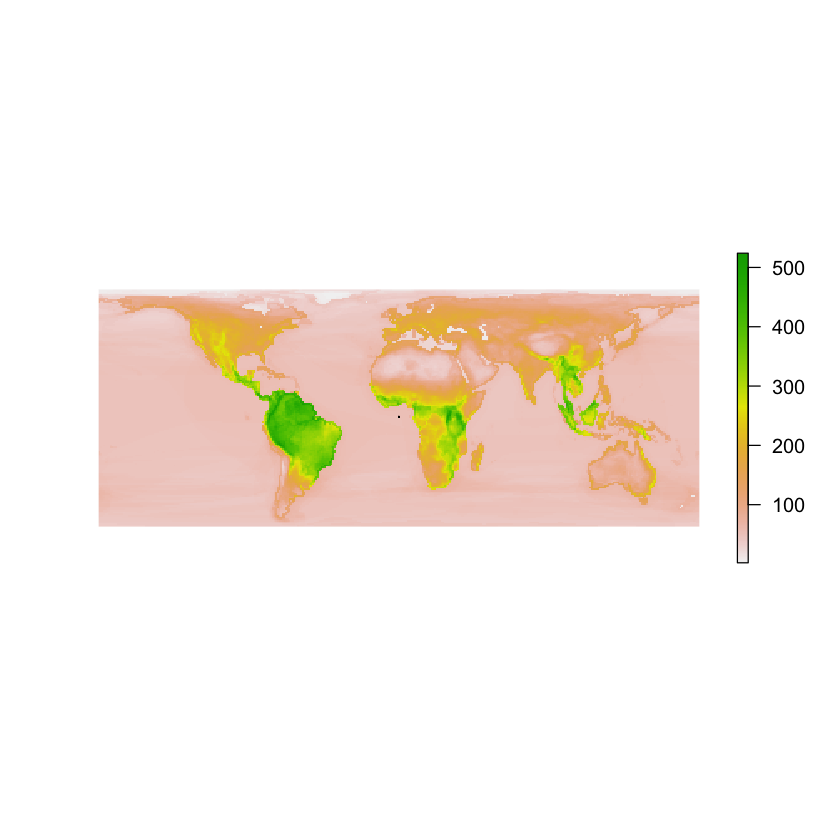

In [276]:
plot(rasters,axes=F,box=FALSE)
plot(world_spatial,add=T)

### Transforming coordinate system

What went wrong here? Do you see the little black dot in the center of the plot? That's our world polygon! It looks like the coordinate system of our raster data does not match with that of the world map polygon (different projections). Let's check the projections of the two objects:

In [277]:
projection(rasters)
projection(world_spatial)

[1] "+proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0"

[1] "+proj=longlat +datum=WGS84 +no_defs"

They are indeed different! You don't need to understand the different projections in detail but all you need to know is how to convert one projection into another. There are different tools to do this, some of the commonly used ones are the `spTransform()` function of the `rgdal` package or the `ptransform()` function of the `proj4` package, but unfortunately those two packages can be complicated to install on some systems, so in this tutorial we stick to the `st_transform()` function which is part of the `sf` package, which we already loaded above. The `st_transform()` function can be used to transform an `sf` object (output of `st_read()` function). This is why we are using the `world` object and not the `SpatialPolygon` object (`world_spatial`) in the following command. All we need to provide is the target projection, so in this case `projection(rasters)`:

In [278]:
transformed_world = st_transform(world,projection(rasters))
transformed_world_spatial = as(transformed_world, 'Spatial')

Let's see what the plot looks like now:

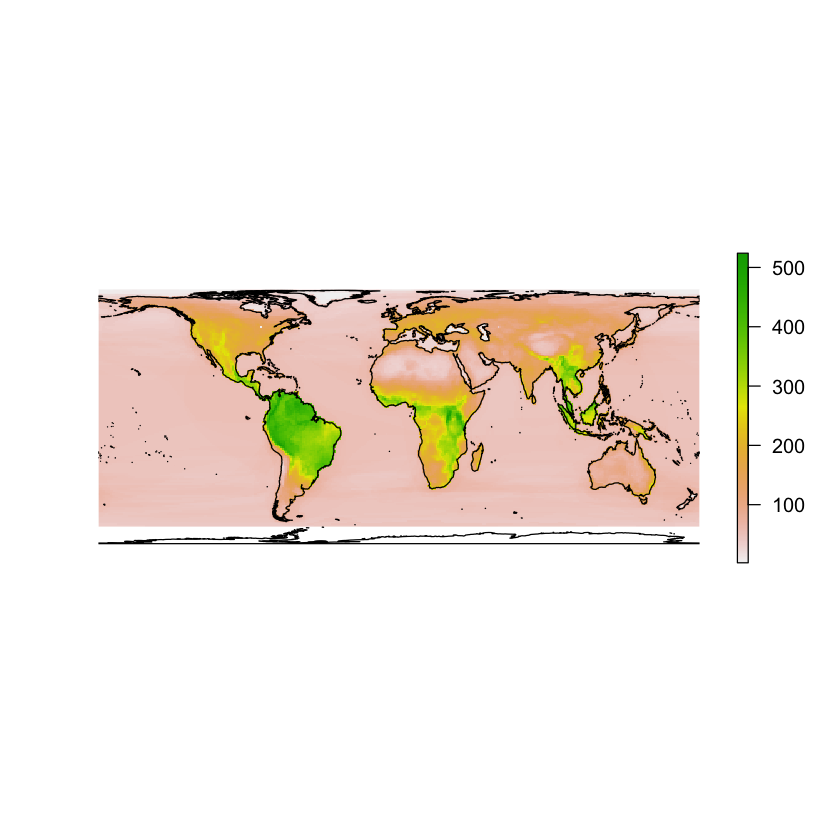

In [279]:
plot(rasters,axes=F,box=FALSE)
plot(transformed_world_spatial,add=T)

### Using mask function to make cell selection

This looks much better, but what if we only want to plot the terrestrial mammal diversity? The reason why also the ocean cells have values in the raster is because of marine mammals, such as whales and dolphins. In case we are only interested in terrestrial mammal diversity, we can use the `mask()` function, which only keeps those cells that are within a given polygon (in this case the world map):

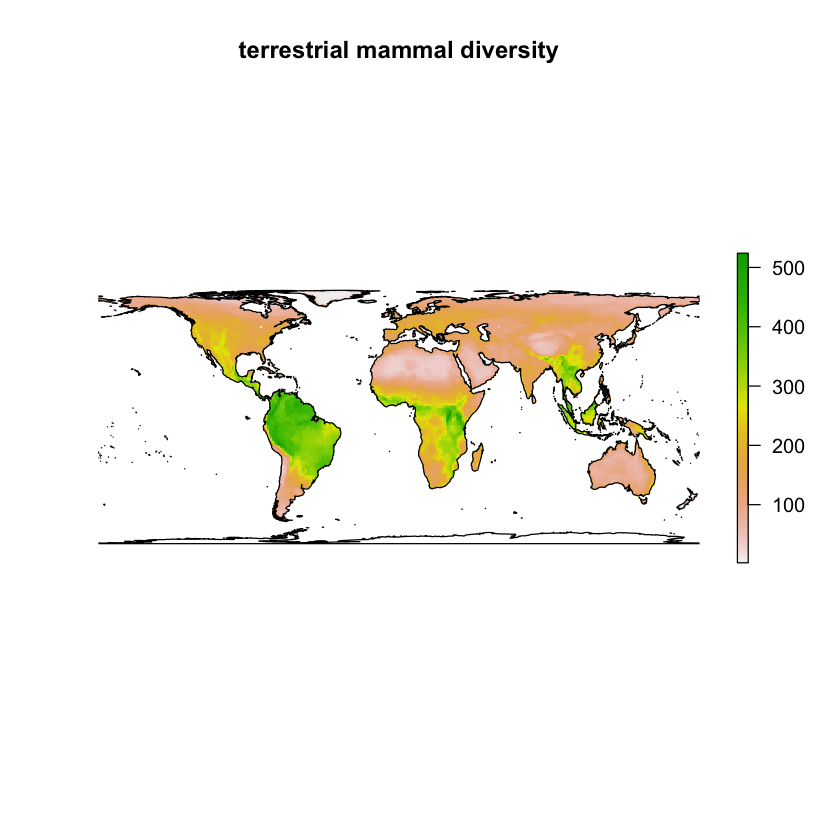

In [280]:
land_cells = mask(rasters,transformed_world_spatial)
plot(land_cells,axes=F,box=FALSE,main='terrestrial mammal diversity')
plot(transformed_world_spatial,add=T)

You can store the plot as a pdf file to look at it in some more detail:

In [281]:
pdf("./plots/terrestrial_mammal_diversity.pdf")
plot(land_cells,axes=F,box=FALSE,main='terrestrial mammal diversity')
plot(transformed_world_spatial,add=T)
dev.off()

pdf 
  2

<div class="alert alert-block alert-warning">
Task: Now plot the mammal species diversity for a country of your choice. Don't forget to transform the polygon to the right coordinate projection!
</div>


<div class="alert alert-block alert-success">
Tip: If you want to restrict the plot to only your region of interest you can do this the easiest by first plotting your (transformed) country polygon. This will make sure that the plot is centered on your region of interest. Then plot the raster on top of the polygon and then plot the polygon again, in order to make the polygon borders visible.
</div>

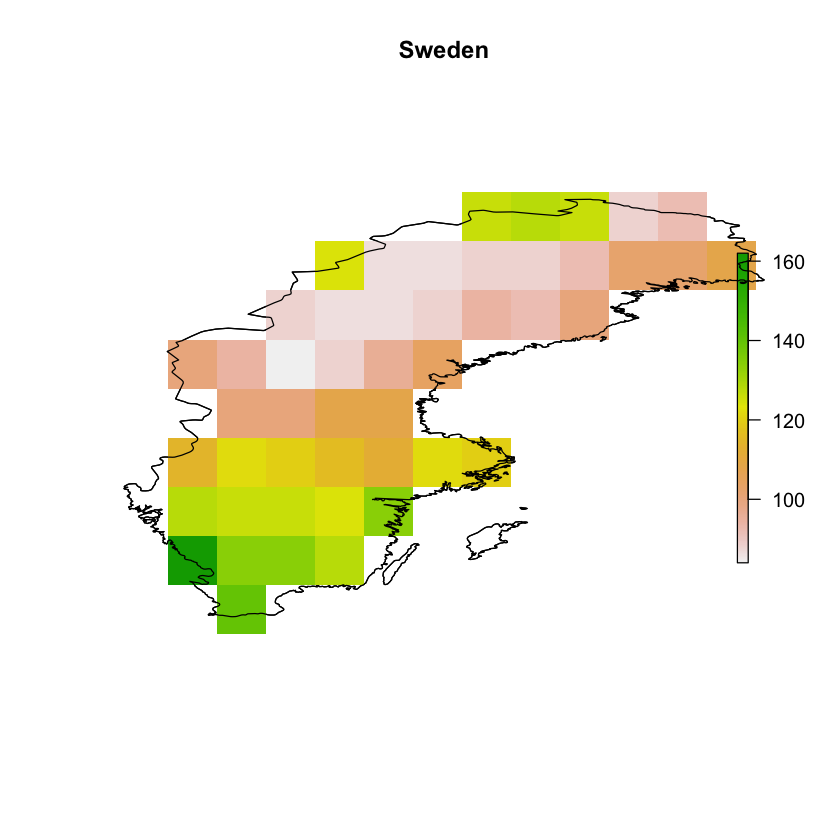

### Transform matrix of coordinates into desired projection

What if we want to transform a matrix of coordinates that we have loaded into R into any given projection? For example let's try to plot the eagle data from earlier on the transformed map from the previous section (choose your species and country).

We first need to tell R what projection our coordinates are representing. You might find this information stored in the metadata that came with your occurrence files or if you collected the data yourself you may be able to find the information in the settings of your GPS device. However, if you have no idea what the projection of your coordinates is, look at the values of your coordinates and try to make out waht reference system they might stem from. Often a good first guess is `'+proj=longlat +datum=WGS84'`.

In our case the data indeed is in `'+proj=longlat +datum=WGS84'`, so we can use the `CRS()` command from the `sp` package to turn this string into a coordinate reference system object.


In [282]:
library(sp)

crdref <- CRS('+proj=longlat +datum=WGS84')
class(crdref)

[1] "CRS"
attr(,"package")
[1] "sp"

Now we use this information when transforming our coordinates into a `SpatialPoints` object, by setting the argument `proj4string=` to `crdref`, which we defined in the previous step:

In [283]:
eagle_data_spatial <- SpatialPoints(locations,proj4string=crdref)

In order to transform our `SpatialPoints` object into our desired projection, which is the projection of our rasters from earlier (`target_projection`), we can again use the `st_transform()` function, just as we did earlier for converting the world map polygon into the correct projection. However before we can use that function we need to convert our `SpatialPoints` object into a `sf` object (the function `st_transform()` only works for `sf` objects. We can simply do that using the `st_as_sf()` function, as shown below:

In [284]:
target_projection = projection(rasters)

eagle_data_spatial_sf = st_as_sf(eagle_data_spatial)
eagle_data_spatial_transformed = st_transform(eagle_data_spatial_sf,target_projection)

Now let's plot the data and see if it matches with our map.

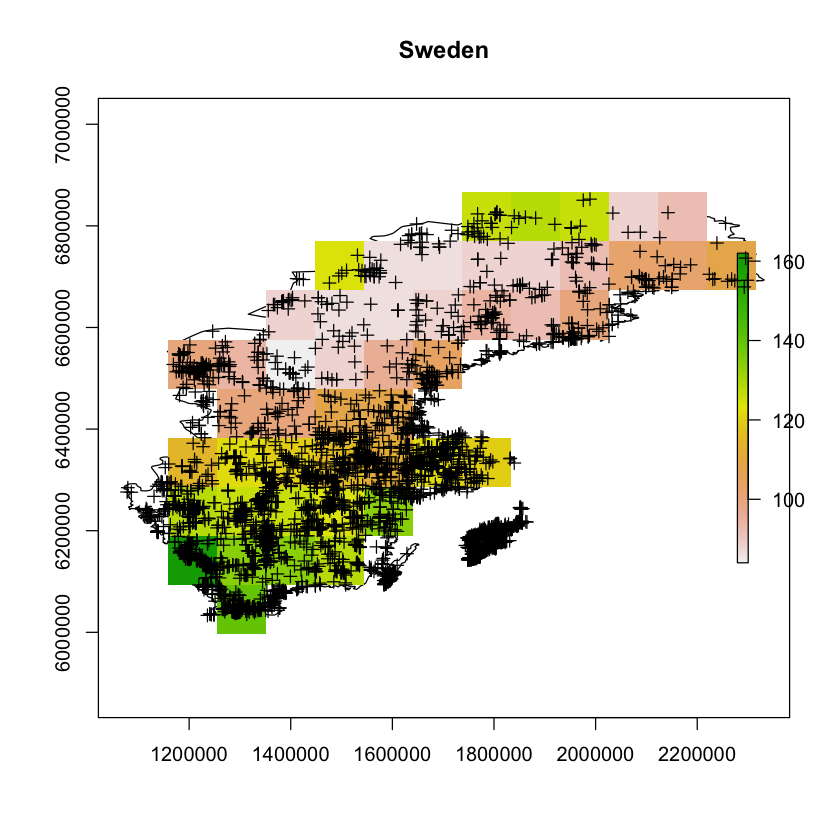

In [285]:
plot(country_transformed_spatial,axes=T,main='Sweden')
plot(country_cells,add=T)
plot(eagle_data_spatial_transformed,pch=3,add=T)

## C) Plotting range of a species

In this part of the tutorial you will extract the current range of a species (data from IUCN) and plot it on top of the present natural range of the same species (where it would exists without human disturbance), in order to visualize the range contraction due to human impact.


First we will read the range polygons of all mammal species. **This will take approximately 2 minutes!**

In [286]:
library(sf)
iucn_mammals = st_read('./data/IUCN_2016_3/MAMMALS.shp')

Reading layer `MAMMALS' from data source `/Users/tobias/GitHub/workshops/ggbc_slw_neic/spatial_r_workshop/data/IUCN_2016_3/MAMMALS.shp' using driver `ESRI Shapefile'
Simple feature collection with 38921 features and 25 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -180 ymin: -85.58276 xmax: 180 ymax: 90
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


### Get species range polygon
The object `iucn_mammals` we just created contains range information for all mammal species. In order to extract the information for a specific species, we can execute the following lines. First specify the species name you are interested in and store it as `species=`:

In [287]:
species = 'Loxodonta africana'

indeces = which(iucn_mammals$binomial == species)
species_polygons = iucn_mammals[indeces,]

class(species_polygons)

[1] "sf"         "data.frame"

### Get species present natural raster
The raster files, which we also used before in this tutorial, are stored at `./data/present_natural_converted/`. Set your working directory to the directory containing the data-folder. Once that is done, you can just use the code below to extract the raster of the species you defined above as `species=`.

In [288]:
setwd('/Users/tobias/GitHub/workshops/ggbc_slw_neic/spatial_r_workshop/')

filename = gsub(" ", "_", species)
file_path = sprintf('./data/present_natural_converted/%s.grd',filename)
species_prenat_raster = raster(file_path)

class(species_prenat_raster)

[1] "RasterLayer"
attr(,"package")
[1] "raster"

<div class="alert alert-block alert-warning">
Task: Use the commands you learned in this tutorial to plot the range of your species of choice on top of the present natural raster of the same species. The resulting plot should look something like this:
</div>

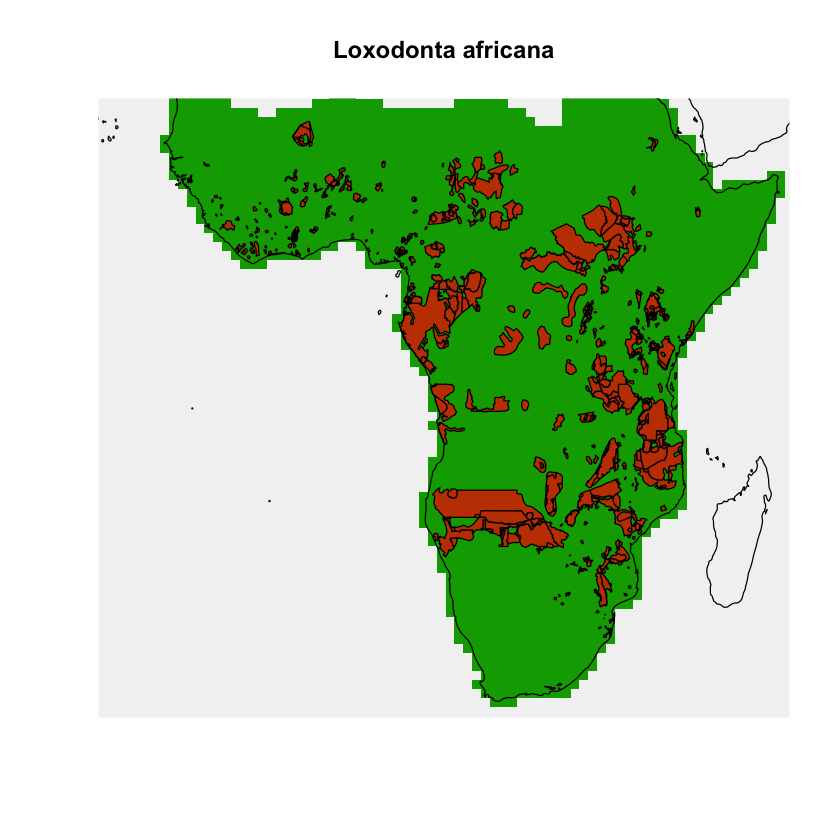

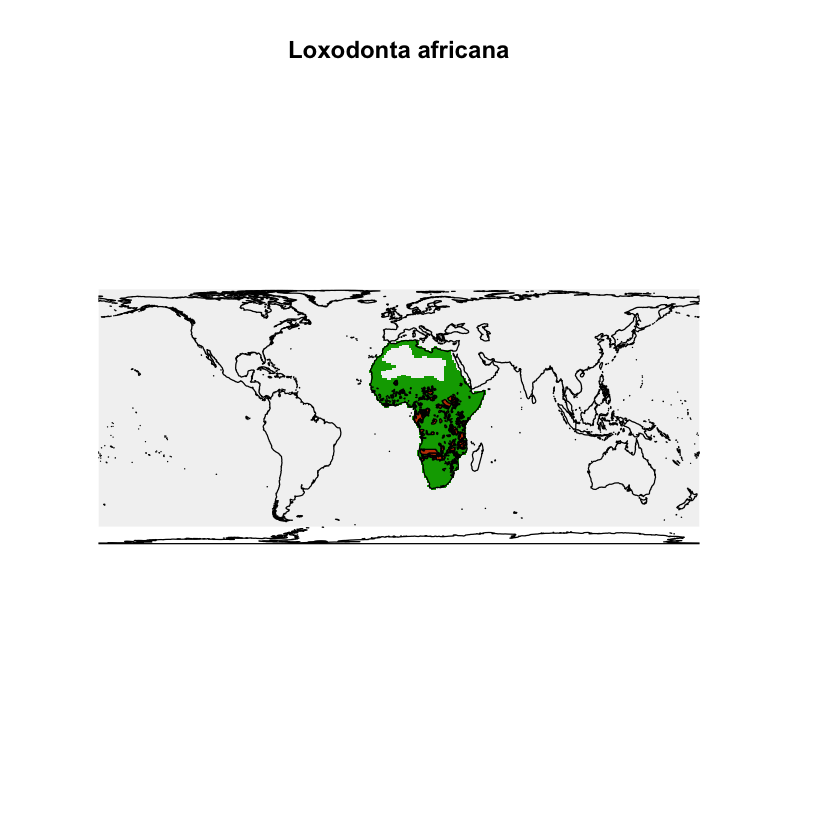